# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。

np.random.seed(1234) #这里有变化，仅需要设置numpy的随机数生成器的种子。设置随机数生成器的种子可以确保每次运行程序时，NumPy生成的随机数序列都是一样的。

# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [2]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], bias=False))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1], bias=False))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
        
        #print the loss        
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e' % (self.iter, loss.item()) #
            ) #每100次迭代，打印一次迭代次数、总的loss、loss_u和loss_f
        return loss #返回总的loss
    
    def train(self, nIter):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式


        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        #使用SGD优化器优化nIter次
        for epoch in range(nIter):
            u_pred = self.net_u(self.x_u, self.t_u)
            f_pred = self.net_f(self.x_f, self.t_f)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

            # Backward and optimize
            self.optimizer_SGD.zero_grad()
            loss.backward()
            self.optimizer_SGD.step()

            #record the loss value
            self.loss_value.append(loss)


            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights

            #print the loss
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e' % 
                    (
                        epoch, 
                        loss
                    )
                )


        # #使用Adam优化器优化nIter次
        # for epoch in range(nIter):
        #     u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        #     f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
        #     # Backward and optimize
        #     self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        #     loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        #     self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
        #     #record the loss value
        #     self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #     #print the loss
        #     if epoch % 100 == 0:
        #         print(
        #             'It: %d, Loss: %.3e' % 
        #             (
        #                 epoch, 
        #                 loss
        #             ) #每100次迭代，打印一次迭代次数、总的loss
        #         )        
        
        
        
        # # 使用LBFGS优化器优化
        # self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
        # print('The total Iter of LBFGS is %d, the final loss is %e' %(self.iter,self.loss_func()))


        return W
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [5]:
nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 10000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)
#生成配位点训练基础数据
X_f_train = lb + (ub-lb)*lhs(2, N_f)  #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，表示生产的样本有两个特征，共N_f个样本数量，所以返回的是一个形状为（N_f，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本X_f_train。

X_f_train = np.vstack((X_f_train, X_u_train)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train

u_train = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

## Training

In [6]:
#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
weights = model.train(50000)
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

#用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
u_pred, f_pred = model.predict(X_star)
#计算误差（基于2范数）        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#打印误差值
print('Error u: %e' % (error_u))                     



#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
#计算插值方法的误差
Error = np.abs(Exact - U_pred)

It: 0, Loss: 2.857e-01
It: 100, Loss: 2.242e-01
It: 200, Loss: 2.065e-01
It: 300, Loss: 1.769e-01
It: 400, Loss: 1.666e-01
It: 500, Loss: 1.630e-01
It: 600, Loss: 1.578e-01
It: 700, Loss: 1.516e-01
It: 800, Loss: 1.451e-01
It: 900, Loss: 1.370e-01
It: 1000, Loss: 1.232e-01
It: 1100, Loss: 1.194e-01
It: 1200, Loss: 1.177e-01
It: 1300, Loss: 1.165e-01
It: 1400, Loss: 1.155e-01
It: 1500, Loss: 1.148e-01
It: 1600, Loss: 1.142e-01
It: 1700, Loss: 1.137e-01
It: 1800, Loss: 1.132e-01
It: 1900, Loss: 1.127e-01
It: 2000, Loss: 1.120e-01
It: 2100, Loss: 1.114e-01
It: 2200, Loss: 1.106e-01
It: 2300, Loss: 1.098e-01
It: 2400, Loss: 1.088e-01
It: 2500, Loss: 1.076e-01
It: 2600, Loss: 1.062e-01
It: 2700, Loss: 1.045e-01
It: 2800, Loss: 1.024e-01
It: 2900, Loss: 1.000e-01
It: 3000, Loss: 9.753e-02
It: 3100, Loss: 9.531e-02
It: 3200, Loss: 9.359e-02
It: 3300, Loss: 9.227e-02
It: 3400, Loss: 9.119e-02
It: 3500, Loss: 9.027e-02
It: 3600, Loss: 8.947e-02
It: 3700, Loss: 8.876e-02
It: 3800, Loss: 8.813e-0

In [7]:
#打印误差随迭代次数的变化
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

#打印最小的误差值所在的epoch
print(np.argmin(trainloss))
#打印总的epoch
print(len(trainloss))

49894
50000


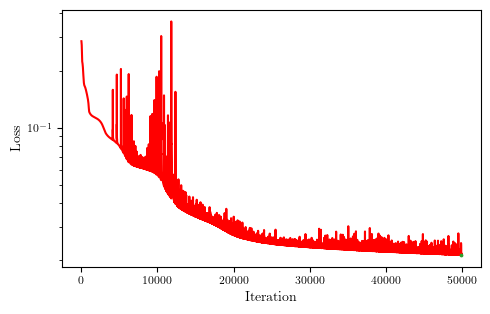

In [8]:
#打印误差随迭代次数的变化
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()
# print(trainloss)
# print(trainloss.shape)
indices=list(range(len(trainloss)))
plt.figure()
# plt.plot(indices[:Adam_iter],trainloss[:Adam_iter],color='red')
# plt.plot(indices[Adam_iter:],trainloss[Adam_iter:],color='blue')

plt.plot(indices,trainloss,color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([40000,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.001]) # 设置y轴的范围
plt.yscale('log')  # 设置y轴为对数尺度




x_optimal = indices[np.argmin(trainloss)] #计算最优点的x坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
y_optimal = trainloss[np.argmin(trainloss)] #计算最优点的y坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
plt.scatter(x_optimal, y_optimal, s=3, marker='o', color='C2', label='Optimal epoch (test loss)', zorder=10) #绘制一个散点图，其中x_optimal和y_optimal是坐标，s表示标记大小，marker表示标记形状o代表圆圈，color表示颜色，label表示图例，zorder表示图层顺序



plt.show()

In [9]:
print(len(weights))
print(len(weights[0]))
# for i in range(len(weights[0])):
#     print(weights[0][i].shape)

print(weights[0][8])
print(weights[0][8].shape)


50000
9
tensor([[-0.2063,  0.0360,  0.0975, -0.1717, -0.1841, -0.0016, -0.1503, -0.2077,
         -0.0096,  0.1025,  0.0555, -0.2209,  0.1959,  0.1230, -0.0111, -0.1546,
         -0.1911, -0.1261,  0.2090,  0.2117]], device='cuda:0')
torch.Size([1, 20])


## Visualizations

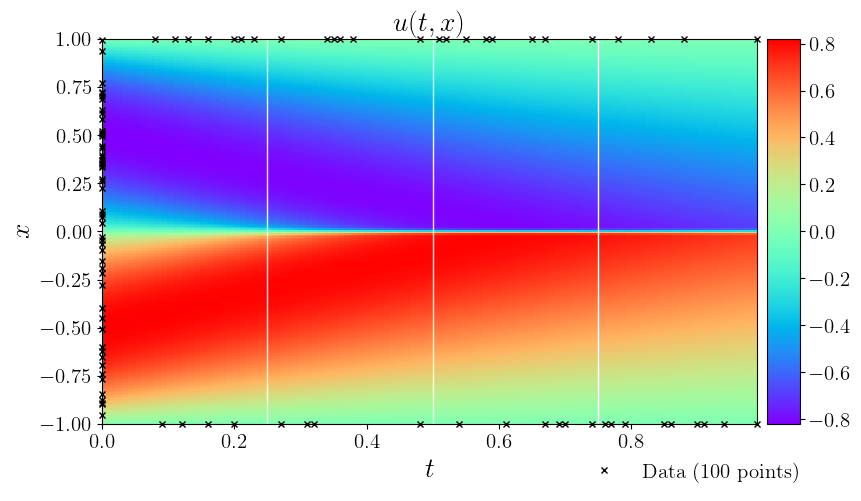

In [10]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  


#在图上绘制三条虚线
line = np.linspace(x.min(), x.max(), 2)[:,None]#生成了一个包含2个等间距的数值的数组，这些数值在 x.min() 到 x.max() 之间。[:,None] 是一个索引操作，用于将一维数组转换为二维数组。这里其实就是[-1;1]
#第一个参数是虚线的x坐标，line是虚线y的坐标，第三个参数是虚线的样式，w表示白色，-表示实线，最后一个参数表示虚线的参数是1
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    


#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

C:\Users\lcy\AppData\Local\Temp\ipykernel_243900\3193111900.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。


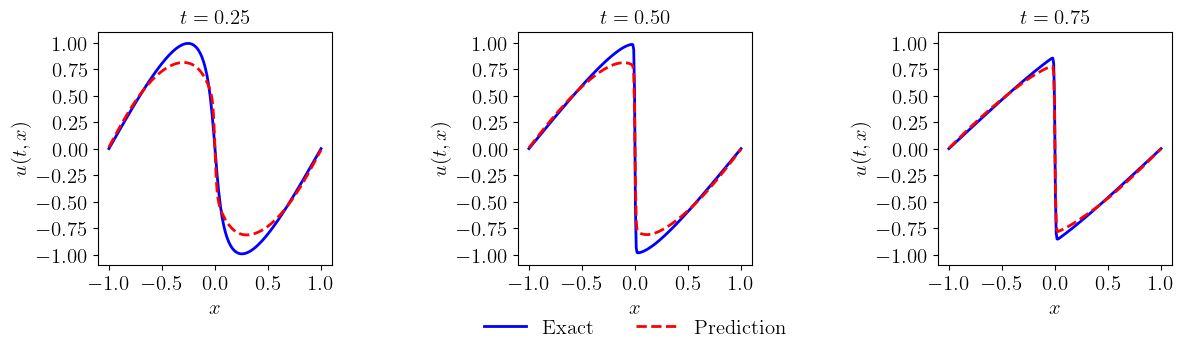

In [11]:
####### Row 1: u(t,x) slices ################## 


fig = plt.figure(figsize=(14, 10))#这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽14英寸高10英寸
ax = fig.add_subplot(111)#在图形的1*1网格的第一个位置添加一个子图

gs1 = gridspec.GridSpec(1, 3)#创建一个1×3的网络，用于存放子图
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)  #更新该网络的参数，第一个表示子图的顶部位置为0.567，第二个参数表示子图的底部位置为0.33，第三个表示子图左侧的位置为0.1，第四个参数表示子图的右侧位置为0.9，第五个参数表示子图之间的宽度为0.5

ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。
#绘制了两条线，一条表示精确值，一条表示预测值
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值     
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$')    #设置子图的y轴的标签为u(t,x)
ax.set_title('$t = 0.25$', fontsize = 15) #设置子图的标题为t=0.25，fontsize=10表示字体大小为15
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第一个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第一个子图的y轴的范围为[-1.1,1.1]
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 1]) #在gs1[0,1]指定的位置，也就是网格的第一行第二列，创建了第二个子图，并将返回的axes对象赋值给ax。
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值    
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第二个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第二个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.50$', fontsize = 15) #设置子图的标题为t=0.50，fontsize=15表示字体大小为15
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)#设置子图的图例，loc='upper center'表示图例的位置是上方中间，bbox_to_anchor=(0.5, -0.15)表示图例的位置是在子图的中间下方0.15的位置，ncol=5表示图例的列数为5，frameon=False表示不显示图例的边框；最后一个参数设置图例属性，接受字典作为参数，这里表示将图例的字体大小设置为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 2]) #在gs1[0,2]指定的位置，也就是网格的第一行第三列，创建了第三个子图，并将返回的axes对象赋值给ax。
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')  #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第三个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第三个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.75$', fontsize = 15) #设置子图的标题为t=0.75，fontsize=15表示字体大小为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。

plt.show() #显示所有打开的图形的函数

In [12]:

#这个模块可以用来读取、写入或更改文件的目录，或者获取操作系统的信息，包含了很多与操作系统交互的函数
import os 
#这个模块用于序列化和反序列化 Python 对象结构，也称为封装和解封装。
#序列化是将 Python 对象转换为字节流的过程，以便可以将其存储到磁盘上，或者通过网络传输到远程位置。反序列化是将这个字节流转换回原始 Python 对象的过程。
import pickle


import argparse #argparse是用来处理命令行参数的工具，提供了一种方便的方式来定义用户应该如何指定/处理这些参数
import time


import matplotlib.pyplot as plt
import numpy as np
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io as spio #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
import seaborn as sns #seaborn是一个基于matplotlib的python数据可视化库，提供了一种高级接口，用于绘制有吸引力切信息丰富的统计图形。
#matplotlib.lines是python数据可视化库matplotlib中一个模块，包含了一些用于创建和操作线条对象的类和函数
#Line2D是该模块中一个类，表示一个二维线条。Line2D的实力可以用于在图形中绘制线条并设置线条的各种属性
from matplotlib.lines import Line2D

In [13]:
#定义一个函数，接受三个参数
def calculate_separation(num_bins):

    num_neurons = 20 #暂定
    J = 1.0 #初始化J
    results = [] #初始化results
    for i in range(1, num_bins+1): #循环args.num_bins次，代表纵轴
        result = []
        _beta =J*i*2.0/40 #计算_beta值

        for j in range(-int(num_bins/2), num_bins+1): #j从-int(args.num_bins/2)到args.num_bins循环，代表横轴
            _J0 = J * j * 2.0 / num_bins #计算_J0值
            W = set_weight(L=num_neurons, J=J, J0=_J0, beta=_beta) #调用set_weight函数，生成一个权重矩阵W，用来初始化
            array = get_chaos(W) #调用get_chaos函数，计算混沌程度
            result.append(array) #将array添加到result中
            print('子循环从-二分之numbins到numbins,当前为第{}次'.format(j))

        results.append(result) #将result添加到results中
        print('循环num_bins,当前为第{}次'.format(i))

    results = np.array(results) #将results转换为numpy数组
    return results #返回results，这是一个三维数组，第三维是三个值（第一个是高斯距离），代表混沌度，第二维是横轴的3/2num_bins个混沌度，第三维是纵轴的num_bins个横轴


#定义一个函数set_weight，接受四个参数
def set_weight(L, J, J0, beta):
    N = L * L
    return np.random.normal(J0/N, J/L, (N, N)) / beta #返回一个N*N的矩阵，矩阵中的元素是从均值为J0/L^2，标准差为J/N的正态分布中随机抽取的，最后将这个随机数矩阵除以beta

#定义一个函数，接受一个参数为矩阵，计算混沌度，是一个包含三个数据的列表，第一个代表欧氏距离的均值，第二个和第三个代表无噪声输入
def get_chaos(W):
    num_iter=500 #迭代次数
    N = W.shape[0] #N是权重W的行数
    N_yc=8 #神经网络隐藏层层数

    # 利用x0计算xt，存储在xs中
    x0 = np.random.normal(0, 1, N) #生成一个均值为0，标准差为1的N维正态分布随机数向量x0
    x = x0 #将x0赋值给x
    xs = [] #初始化xs
    for i in range(num_iter): #循环num_iter次
        for j in range(N_yc): #几个隐藏层就执行几次
            x = np.matmul(x, W) #x=x*W  
            x = np.tanh(x) #x=tanh(x)
        # x = np.matmul(x, W) #x=x*W
        # if args.activation_func == 'relu': #如果激活函数是relu
        #     x = np.maximum(x, 0) #x=max(x,0)
        # elif args.activation_func == 'tanh': #如果激活函数是tanh
        #     x = np.tanh(x) #x=tanh(x)
        xs.append(x) #将x的数据添加到xs中

    # 利用x1(x0')计算xt'，存储在xs1中
    x1 = x0 + np.random.normal(0, 0.0001, N) #x1是x0加上一个均值为0，标准差为0.0001的N维正态分布随机数向量（极小量），论文中的x0'
    # x1 = x0 + 0.0001 * np.ones(N)
    x = x1 #将x1赋值给x
    xs1 = [] #初始化xs1
    for i in range(num_iter): #循环num_iter次
        for j in range(N_yc): #几个隐藏层就执行几次
            x1 = np.matmul(x1, W) #x1=x1*W
            x1 = np.tanh(x1) #x1=tanh(x1)
        # x1 = np.matmul(x1, W) #x1=x1*W
        # if args.activation_func == 'relu': #如果激活函数是relu
        #     x1 = np.maximum(x1, 0) #x1=max(x1,0)
        # elif args.activation_func == 'tanh': #如果激活函数是tanh        
        xs1.append(x1) #将x1的数据添加到xs1中

    # separation,计算xs和xs1的分离度，这个分离度是xs和xs1在最后num_iter/5个时间步骤的平均欧式距离
    separation = np.mean(np.linalg.norm(np.array(xs)-np.array(xs1), axis=1)[-num_iter//5:])  #先将xs和xs1转换为numpy数组，然后计算他们的差值，再计算这个差数组的范数（可视为欧氏距离），然后利用切片操作获得后num_iter/5个时间步骤的数据，最后计算这几个欧氏距离的平均值
    u = np.mean(xs[-num_iter//5:]) #计算xs在最后num_iter/5个时间步骤的平均值
    b = np.mean(xs[-num_iter//5:], axis=0)
    q0 = np.mean(np.power(b, 2)) #计算xs在最后num_iter/5个时间步骤的平均值的平方

    return np.array([separation, u, q0]) #返回包含separation、u、q0的数组



def prepare_xy(results):

    # 准备横纵轴标签
    betas = [i*2/num_bins for i in range(1,num_bins+1)] #计算betas的值，即相位图x的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从1到args.num_bins的整数
    J0s = [i*2/num_bins for i in range(-int(num_bins/2), num_bins+1)] #计算J0s的值，即相位图y的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从-int(args.num_bins/2)到args.num_bins的整数
    betas = ['' for i in range(9)] + [str(beta) if i % 10 == 0 else '' for i, beta in enumerate(betas[9:])] #首先生成了一个包含24个空字符串的列表，然后将其与另一个列表拼接起来，拼接的新列表通过遍历betas列表（从第二十五个元素开始）并将每个元素转换为字符串得到新的列表，但只有当元素的索引i是25的倍数时才进行转换，否则就添加一个空字符串
    J0s = [str(J0) if i % 20 == 0 else '' for i, J0 in enumerate(J0s)] #通过遍历J0s列表并将每个元素转化为字符串得到新的列表，但只有当元素的索引i是50的倍数时才进行转换，否则就添加一个空字符串

    #预处理混沌度数据，具体支取
    results1 = results

    separation1 = results1[::-1, :, 0] #取出results1中的第一个维度所有元素并反转顺序、第二个维度所有元素、第三个维度的第一个元素，最后将这个三维数组赋值给separation1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    separation1[separation1 > 1] = 1 #将separation1中大于1的元素赋值为1，用于限制数组的最大值
    separation1_log = np.log10(np.abs(separation1)+0.0001)[:, :] #计算separation1的绝对值加上0.0001的对数，然后赋值给separation1_log

    return betas, J0s, separation1_log#返回betas、J0s、separation1_log、integrals、mask

#定义一个函数，接受两个参数args和fname，用于绘制混沌热图
def plot_separation(results): 
    '''Plot the result
    '''
    # Prepare xy axis and separation data
    betas, J0s, separation1_log= prepare_xy(results) #传入参数args和fname，调用下面的prepare_xy函数，获取betas、J0s、separation1_log
    fig, ax = plt.subplots(figsize=(9, 6.5)) #创建一个新的图形和子图，指定子图的行数为1，列数未指定（默认为1），整个图形的大小为9*6.5英寸

    # Plot separation
    ax = sns.heatmap(separation1_log, xticklabels=J0s,yticklabels=betas[::-1], cmap='Purples') 
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24, rotation=0) #设置子图ax的x轴刻度标签，函数ax.get_xticklabels()的作用是获取当前x轴的刻度标签，返回一个标签列表;而ax.set_xticklabels()函数的作用是设置x轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=24, rotation=0) #设置子图ax的y轴刻度标签，函数ax.get_yticklabels()的作用是获取当前y轴的刻度标签，返回一个标签列表;而ax.set_yticklabels()函数的作用是设置y轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    # ax.set_title(
    #     'Sensitivity under perturbation $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24)

    
    # Plot colorbar，绘制颜色条
    cbar = ax.collections[0].colorbar #获取热图的颜色条，颜色条用于表示颜色和数据值之间的对应关系
    cbar.set_label('Asymptotic distance $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24) #设置热图颜色条的标签，字体大小为24
    # if args.activation_func == 'relu': #如果激活函数是relu
    #     #设置颜色条的刻度
    #     cbar_labels1 = [-5,-2,0,2] #定义一个新列表，用来设置热图颜色条的刻度标签
    #     cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-5，-2，0，2处
    #     #设置颜色条的刻度标签
    #     cbar_labels2 = ['< {}'.format(.00001), str(0.01), str(1.0), '>= {}'.format(100)] #再定义一个新列表，包含了颜色条的刻度标签
    #     cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.00001，0.01，1.0，>=100
    #     cbar.ax.tick_params(labelsize=22) #设置热图颜色条刻度标签的字体大小为22
    cbar_labels1=[-4,-2,0] #定义一个新列表，用来设置热图颜色条的刻度    
    cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-4，-2，0处
    cbar_labels2 = ['< {}'.format(.0001), str(0.01), '>= {}'.format(1)] #再定义一个新列表，包含了颜色条的刻度标签
    cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.0001，0.01，>=1
    cbar.ax.tick_params(labelsize=24) #设置热图颜色条刻度标签的字体大小为24

    # Plot order-chaos boundary using data.mat file，利用matlab文件绘制理论计算混沌边缘
    # sns.heatmap(integrals, xticklabels=J0s,yticklabels=betas[::-1], mask=mask, cmap='bwr', cbar=False, vmin=0, vmax=1) #调用sns库中的heatmap函数再子图ax上绘制热图，热图数据来源于integrals，x轴来自于J0s，y轴来自于betas（反转顺序）；
                                                                                                                       #mask参数是一个布尔数组，形状与integrals相同，mask对应索引为True的位置不会在热图中显示；cmap表示颜色映射，这里是蓝色（低值）到白色（中值）再到红色（高值）
                                                                                                                       #cbar为false表示不显示颜色条，vmin和vmax分别表示数据的最小值和最大值                          
    ax.set_xlabel('$J_0/\ J$', fontsize=24) #设置x轴标签为$J_0/\ J$，字体大小为24
    ax.set_ylabel('$1/\ J$', fontsize=24) #设置y轴标签为$1/\ J$，字体大小为24
    
    
    # # Manually add a legend，手动添加一个图例到图形中
    # handles, labels = ax.get_legend_handles_labels() #调用函数获取当前子图ax已有的图例句柄和标签，图例句柄通常是代表图例中每个条目的图形元素（如线条、点等），而图例标签则是这些元素的描述
    # lines = Line2D([0], [0], color='red', linewidth=5, linestyle='-') #创建一个线段（Line2D）对象，用于表示一个二维线条，这里的线条是红色的，线宽为5，线型为实线
    # label = 'Edge of chaos' #图例的标签为Edge of chaos
    # handles.insert(0, lines) #将上面创建的线段对象插入到已有图例句柄列表的第一个位置
    # labels.insert(0, label) #将图例标签插入到已有图例标签列表的第一个位置
    # plt.legend(handles=handles, labels=labels, fontsize=24, loc='upper left') #调用plt.legend函数添加图例，图例的句柄和标签分别来自于上面更新后的handles和labels，字体大小为24，图例的位置在左上角

    fig.tight_layout() #调整子图布局，是的子图之间的距离适当，以及子图与图形边界的距离适当

    plt.show() #显示图形


子循环从-二分之numbins到numbins,当前为第-20次
子循环从-二分之numbins到numbins,当前为第-19次
子循环从-二分之numbins到numbins,当前为第-18次
子循环从-二分之numbins到numbins,当前为第-17次
子循环从-二分之numbins到numbins,当前为第-16次
子循环从-二分之numbins到numbins,当前为第-15次
子循环从-二分之numbins到numbins,当前为第-14次
子循环从-二分之numbins到numbins,当前为第-13次
子循环从-二分之numbins到numbins,当前为第-12次
子循环从-二分之numbins到numbins,当前为第-11次
子循环从-二分之numbins到numbins,当前为第-10次
子循环从-二分之numbins到numbins,当前为第-9次
子循环从-二分之numbins到numbins,当前为第-8次
子循环从-二分之numbins到numbins,当前为第-7次
子循环从-二分之numbins到numbins,当前为第-6次
子循环从-二分之numbins到numbins,当前为第-5次
子循环从-二分之numbins到numbins,当前为第-4次
子循环从-二分之numbins到numbins,当前为第-3次
子循环从-二分之numbins到numbins,当前为第-2次
子循环从-二分之numbins到numbins,当前为第-1次
子循环从-二分之numbins到numbins,当前为第0次
子循环从-二分之numbins到numbins,当前为第1次
子循环从-二分之numbins到numbins,当前为第2次
子循环从-二分之numbins到numbins,当前为第3次
子循环从-二分之numbins到numbins,当前为第4次
子循环从-二分之numbins到numbins,当前为第5次
子循环从-二分之numbins到numbins,当前为第6次
子循环从-二分之numbins到numbins,当前为第7次
子循环从-二分之numbins到numbins,当前为第8次
子循环从-二分之numbins到numbins,当前为第9次
子循环从-二分之numbins到numbins,当前为第10次
子循环从-二分

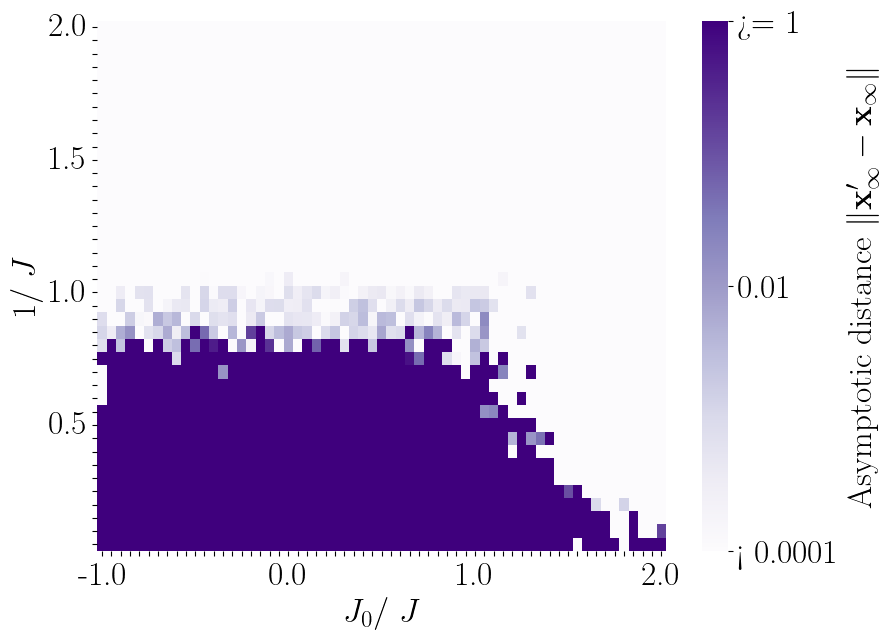

In [14]:
num_bins=40
results=calculate_separation(num_bins)
plot_separation(results)

In [18]:
print(results.shape)

(40, 61, 3)


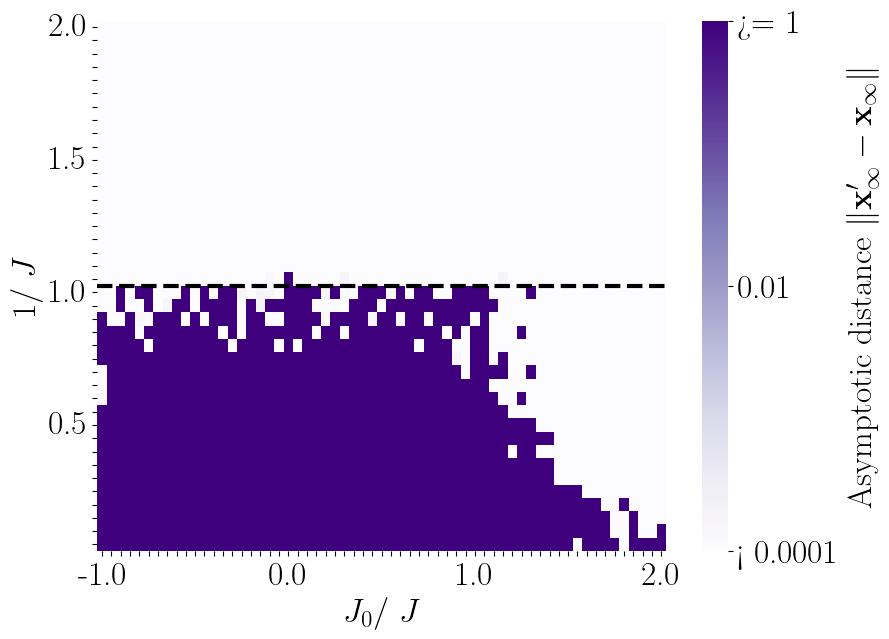

In [26]:
def prepare_xy1(results):

    # 准备横纵轴标签
    betas = [i*2/num_bins for i in range(1,num_bins+1)] #计算betas的值，即相位图x的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从1到args.num_bins的整数
    J0s = [i*2/num_bins for i in range(-int(num_bins/2), num_bins+1)] #计算J0s的值，即相位图y的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从-int(args.num_bins/2)到args.num_bins的整数
    betas = ['' for i in range(9)] + [str(beta) if i % 10 == 0 else '' for i, beta in enumerate(betas[9:])] #首先生成了一个包含24个空字符串的列表，然后将其与另一个列表拼接起来，拼接的新列表通过遍历betas列表（从第二十五个元素开始）并将每个元素转换为字符串得到新的列表，但只有当元素的索引i是25的倍数时才进行转换，否则就添加一个空字符串
    J0s = [str(J0) if i % 20 == 0 else '' for i, J0 in enumerate(J0s)] #通过遍历J0s列表并将每个元素转化为字符串得到新的列表，但只有当元素的索引i是50的倍数时才进行转换，否则就添加一个空字符串

    #预处理混沌度数据，具体支取
    results1 = results

    separation1 = results1[::-1, :, 0] #取出results1中的第一个维度所有元素并反转顺序、第二个维度所有元素、第三个维度的第一个元素，最后将这个三维数组赋值给separation1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    separation1[separation1 > 0.0001] = 1 #将separation1中大于1的元素赋值为1，用于限制数组的最大值
    separation1_log = np.log10(np.abs(separation1)+0.0001)[:, :] #计算separation1的绝对值加上0.0001的对数，然后赋值给separation1_log
    # separation1_log = np.abs(separation1)[:, :] #计算separation1的绝对值加上0.0001的对数，然后赋值给separation1_log
    return betas, J0s, separation1_log#返回betas、J0s、separation1_log、integrals、mask

#定义一个函数，接受两个参数args和fname，用于绘制混沌热图
def plot_separation1(results): 
    '''Plot the result
    '''
    # Prepare xy axis and separation data
    betas, J0s, separation1_log= prepare_xy1(results) #传入参数args和fname，调用下面的prepare_xy函数，获取betas、J0s、separation1_log
    fig, ax = plt.subplots(figsize=(9, 6.5)) #创建一个新的图形和子图，指定子图的行数为1，列数未指定（默认为1），整个图形的大小为9*6.5英寸

    # Plot separation
    ax = sns.heatmap(separation1_log, xticklabels=J0s,yticklabels=betas[::-1], cmap='Purples') 
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24, rotation=0) #设置子图ax的x轴刻度标签，函数ax.get_xticklabels()的作用是获取当前x轴的刻度标签，返回一个标签列表;而ax.set_xticklabels()函数的作用是设置x轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=24, rotation=0) #设置子图ax的y轴刻度标签，函数ax.get_yticklabels()的作用是获取当前y轴的刻度标签，返回一个标签列表;而ax.set_yticklabels()函数的作用是设置y轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    # ax.set_title(
    #     'Sensitivity under perturbation $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24)

    
    # Plot colorbar，绘制颜色条
    cbar = ax.collections[0].colorbar #获取热图的颜色条，颜色条用于表示颜色和数据值之间的对应关系
    cbar.set_label('Asymptotic distance $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24) #设置热图颜色条的标签，字体大小为24
    # if args.activation_func == 'relu': #如果激活函数是relu
    #     #设置颜色条的刻度
    #     cbar_labels1 = [-5,-2,0,2] #定义一个新列表，用来设置热图颜色条的刻度标签
    #     cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-5，-2，0，2处
    #     #设置颜色条的刻度标签
    #     cbar_labels2 = ['< {}'.format(.00001), str(0.01), str(1.0), '>= {}'.format(100)] #再定义一个新列表，包含了颜色条的刻度标签
    #     cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.00001，0.01，1.0，>=100
    #     cbar.ax.tick_params(labelsize=22) #设置热图颜色条刻度标签的字体大小为22
    cbar_labels1=[-4,-2,0] #定义一个新列表，用来设置热图颜色条的刻度    
    cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-4，-2，0处
    cbar_labels2 = ['< {}'.format(.0001), str(0.01), '>= {}'.format(1)] #再定义一个新列表，包含了颜色条的刻度标签
    cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.0001，0.01，>=1
    cbar.ax.tick_params(labelsize=24) #设置热图颜色条刻度标签的字体大小为24

    # Plot order-chaos boundary using data.mat file，利用matlab文件绘制理论计算混沌边缘
    # sns.heatmap(integrals, xticklabels=J0s,yticklabels=betas[::-1], mask=mask, cmap='bwr', cbar=False, vmin=0, vmax=1) #调用sns库中的heatmap函数再子图ax上绘制热图，热图数据来源于integrals，x轴来自于J0s，y轴来自于betas（反转顺序）；
                                                                                                                       #mask参数是一个布尔数组，形状与integrals相同，mask对应索引为True的位置不会在热图中显示；cmap表示颜色映射，这里是蓝色（低值）到白色（中值）再到红色（高值）
                                                                                                                       #cbar为false表示不显示颜色条，vmin和vmax分别表示数据的最小值和最大值                          
    ax.set_xlabel('$J_0/\ J$', fontsize=24) #设置x轴标签为$J_0/\ J$，字体大小为24
    ax.set_ylabel('$1/\ J$', fontsize=24) #设置y轴标签为$1/\ J$，字体大小为24
    
    
    
    # Plot theoretical boundary，绘制理论边界

    plt.axhline(y=(20), color='black', linestyle='--', lw=3) #该函数用于在图形上绘制一条水平线，y是水平线的y坐标，color是线的颜色，linestyle是线的样式，lw是线的宽度，x坐标的默认xmin和xmax是0和1，代表线覆盖了整个x轴范围
    





    fig.tight_layout() #调整子图布局，是的子图之间的距离适当，以及子图与图形边界的距离适当

    plt.show() #显示图形


plot_separation1(results)

In [41]:
mean = []
for epoch in range(len(weights)):
    meanepoch = 0
    for lay in range(len(weights[epoch])):
        mean_value = weights[epoch][lay].mean()
        mean_value_np = mean_value.detach().cpu().numpy()
        meanepoch += mean_value_np

    meanepoch = meanepoch / len(weights[epoch])
    mean.append(meanepoch)


50000
-0.0034927760975228418
[-0.0034927760975228418, -0.003493651385522551, -0.0034948995259280005, -0.0034964848827156755, -0.0034983705134234494, -0.0035005273142208657, -0.0035029277852219013, -0.0035055463150557545, -0.0035083601897996333, -0.0035113522834661934, -0.0035145008005201817, -0.0035177917969930503, -0.003521210552814106, -0.003524744482193556, -0.0035283846082165837, -0.0035321196127269003, -0.003535941346651978, -0.0035398431743184724, -0.003543820206282867, -0.0035478676048417888, -0.0035519817093801168, -0.003556161575640241, -0.003560404720095297, -0.0035647102631628513, -0.003569080675434735, -0.0035735159181058407, -0.0035780174010950658, -0.003582590013845927, -0.0035872368866370786, -0.0035919599338538116, -0.0035967660886752936, -0.0036016607320764, -0.0036066503315750095, -0.003611740061185426, -0.0036169361297248136, -0.003622248432495528, -0.003627682803198695, -0.0036332493829023507, -0.003638953384425905, -0.003644806501041684, -0.0036508178260798254, -0.

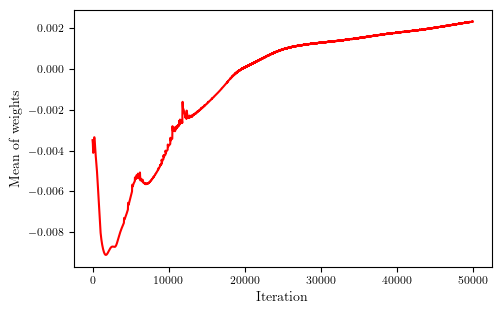

In [49]:
print(len(mean))
print(mean[0])
print(mean)


indices=list(range(len(mean)))
plt.figure()
# plt.plot(indices[:Adam_iter],trainloss[:Adam_iter],color='red')
# plt.plot(indices[Adam_iter:],trainloss[Adam_iter:],color='blue')

plt.plot(indices,mean,color='red')
plt.xlabel('Iteration')
plt.ylabel('Mean of weights')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([40000,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.001]) # 设置y轴的范围
# plt.yscale('log')  # 设置y轴为对数尺度




# x_optimal = indices[np.argmin(trainloss)] #计算最优点的x坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
# y_optimal = trainloss[np.argmin(trainloss)] #计算最优点的y坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
# plt.scatter(x_optimal, y_optimal, s=3, marker='o', color='C2', label='Optimal epoch (test loss)', zorder=10) #绘制一个散点图，其中x_optimal和y_optimal是坐标，s表示标记大小，marker表示标记形状o代表圆圈，color表示颜色，label表示图例，zorder表示图层顺序



plt.show()

In [45]:
std_dev = []
for epoch in range(len(weights)):
    std_epoch = 0
    for lay in range(len(weights[epoch])):
        std_value = weights[epoch][lay].std()
        std_value_np = std_value.detach().cpu().numpy()
        std_epoch += std_value_np

    std_epoch = std_epoch / len(weights[epoch])
    std_dev.append(std_epoch)

50000
0.16370630264282227
[0.16370630264282227, 0.16370455589559343, 0.16370215184158748, 0.16369924942652384, 0.16369603243139055, 0.1636926664246453, 0.16368932525316873, 0.16368616289562649, 0.16368333829773796, 0.163681008749538, 0.16367928352620867, 0.1636783199177848, 0.16367821560965645, 0.1636790715985828, 0.16368098888132307, 0.16368403368526036, 0.16368829707304636, 0.1636938320265876, 0.1637006915277905, 0.16370893021424612, 0.16371858616669974, 0.16372970077726576, 0.16374229391415915, 0.1637563986910714, 0.1637720482216941, 0.16378924250602722, 0.16380802790323892, 0.1638283994462755, 0.16385039024882847, 0.16387400693363613, 0.16389927599165174, 0.16392621397972107, 0.1639548357990053, 0.16398516628477308, 0.1640172302722931, 0.16405103438430363, 0.16408662497997284, 0.16412402192751566, 0.16416325668493906, 0.16420435905456543, 0.16424736380577087, 0.1642923139863544, 0.16433924436569214, 0.16438820130295223, 0.1644392278459337, 0.16449237366517386, 0.16454767684141794, 

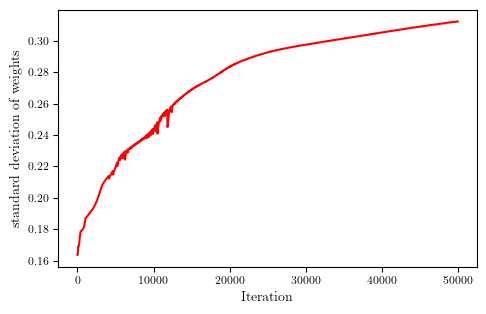

In [50]:
print(len(std_dev))
print(std_dev[0])
print(std_dev)

indices=list(range(len(std_dev)))
plt.figure()
# plt.plot(indices[:Adam_iter],trainloss[:Adam_iter],color='red')
# plt.plot(indices[Adam_iter:],trainloss[Adam_iter:],color='blue')

plt.plot(indices, std_dev, color='red')
plt.xlabel('Iteration')
plt.ylabel('standard deviation of weights')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([40000,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.001]) # 设置y轴的范围
# plt.yscale('log')  # 设置y轴为对数尺度




# x_optimal = indices[np.argmin(trainloss)] #计算最优点的x坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
# y_optimal = trainloss[np.argmin(trainloss)] #计算最优点的y坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
# plt.scatter(x_optimal, y_optimal, s=3, marker='o', color='C2', label='Optimal epoch (test loss)', zorder=10) #绘制一个散点图，其中x_optimal和y_optimal是坐标，s表示标记大小，marker表示标记形状o代表圆圈，color表示颜色，label表示图例，zorder表示图层顺序



plt.show()

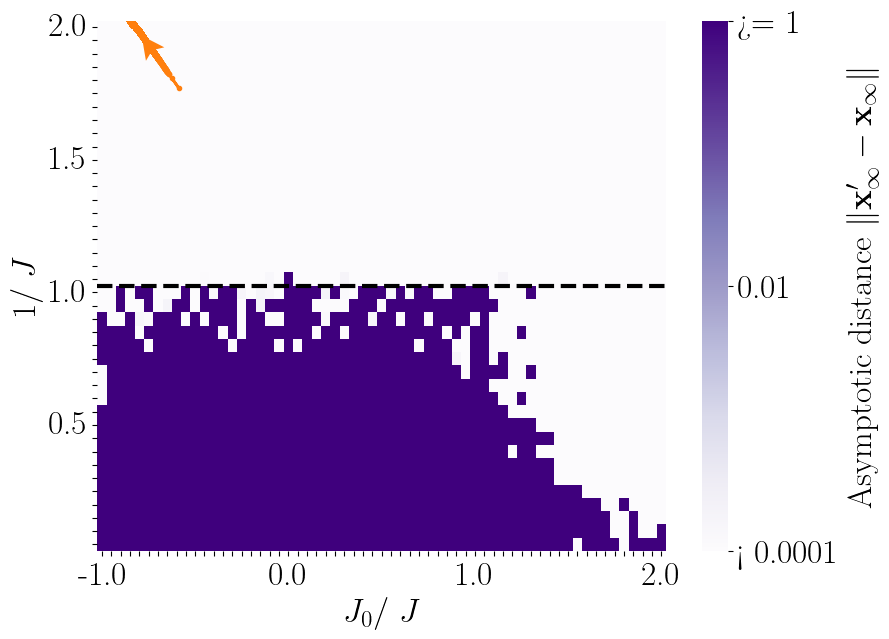

In [88]:
def prepare_xy1(results):

    # 准备横纵轴标签
    betas = [i*2/num_bins for i in range(1,num_bins+1)] #计算betas的值，即相位图x的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从1到args.num_bins的整数
    J0s = [i*2/num_bins for i in range(-int(num_bins/2), num_bins+1)] #计算J0s的值，即相位图y的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从-int(args.num_bins/2)到args.num_bins的整数
    betas = ['' for i in range(9)] + [str(beta) if i % 10 == 0 else '' for i, beta in enumerate(betas[9:])] #首先生成了一个包含24个空字符串的列表，然后将其与另一个列表拼接起来，拼接的新列表通过遍历betas列表（从第二十五个元素开始）并将每个元素转换为字符串得到新的列表，但只有当元素的索引i是25的倍数时才进行转换，否则就添加一个空字符串
    J0s = [str(J0) if i % 20 == 0 else '' for i, J0 in enumerate(J0s)] #通过遍历J0s列表并将每个元素转化为字符串得到新的列表，但只有当元素的索引i是50的倍数时才进行转换，否则就添加一个空字符串

    #预处理混沌度数据，具体支取
    results1 = results

    separation1 = results1[::-1, :, 0] #取出results1中的第一个维度所有元素并反转顺序、第二个维度所有元素、第三个维度的第一个元素，最后将这个三维数组赋值给separation1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    separation1[separation1 > 0.0001] = 1 #将separation1中大于1的元素赋值为1，用于限制数组的最大值
    separation1_log = np.log10(np.abs(separation1)+0.0001)[:, :] #计算separation1的绝对值加上0.0001的对数，然后赋值给separation1_log
    # separation1_log = np.abs(separation1)[:, :] #计算separation1的绝对值加上0.0001的对数，然后赋值给separation1_log
    return betas, J0s, separation1_log#返回betas、J0s、separation1_log、integrals、mask

#定义一个函数，接受两个参数args和fname，用于绘制混沌热图
def plot_separation1(results, mean, std_dev): 
    '''Plot the result
    '''
    # Prepare xy axis and separation data
    betas, J0s, separation1_log= prepare_xy1(results) #传入参数args和fname，调用下面的prepare_xy函数，获取betas、J0s、separation1_log
    fig, ax = plt.subplots(figsize=(9, 6.5)) #创建一个新的图形和子图，指定子图的行数为1，列数未指定（默认为1），整个图形的大小为9*6.5英寸

    # Plot separation
    ax = sns.heatmap(separation1_log, xticklabels=J0s,yticklabels=betas[::-1], cmap='Purples') 
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24, rotation=0) #设置子图ax的x轴刻度标签，函数ax.get_xticklabels()的作用是获取当前x轴的刻度标签，返回一个标签列表;而ax.set_xticklabels()函数的作用是设置x轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=24, rotation=0) #设置子图ax的y轴刻度标签，函数ax.get_yticklabels()的作用是获取当前y轴的刻度标签，返回一个标签列表;而ax.set_yticklabels()函数的作用是设置y轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    # ax.set_title(
    #     'Sensitivity under perturbation $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24)

    
    # Plot colorbar，绘制颜色条
    cbar = ax.collections[0].colorbar #获取热图的颜色条，颜色条用于表示颜色和数据值之间的对应关系
    cbar.set_label('Asymptotic distance $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24) #设置热图颜色条的标签，字体大小为24
    # if args.activation_func == 'relu': #如果激活函数是relu
    #     #设置颜色条的刻度
    #     cbar_labels1 = [-5,-2,0,2] #定义一个新列表，用来设置热图颜色条的刻度标签
    #     cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-5，-2，0，2处
    #     #设置颜色条的刻度标签
    #     cbar_labels2 = ['< {}'.format(.00001), str(0.01), str(1.0), '>= {}'.format(100)] #再定义一个新列表，包含了颜色条的刻度标签
    #     cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.00001，0.01，1.0，>=100
    #     cbar.ax.tick_params(labelsize=22) #设置热图颜色条刻度标签的字体大小为22
    cbar_labels1=[-4,-2,0] #定义一个新列表，用来设置热图颜色条的刻度    
    cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-4，-2，0处
    cbar_labels2 = ['< {}'.format(.0001), str(0.01), '>= {}'.format(1)] #再定义一个新列表，包含了颜色条的刻度标签
    cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.0001，0.01，>=1
    cbar.ax.tick_params(labelsize=24) #设置热图颜色条刻度标签的字体大小为24

    # Plot order-chaos boundary using data.mat file，利用matlab文件绘制理论计算混沌边缘
    # sns.heatmap(integrals, xticklabels=J0s,yticklabels=betas[::-1], mask=mask, cmap='bwr', cbar=False, vmin=0, vmax=1) #调用sns库中的heatmap函数再子图ax上绘制热图，热图数据来源于integrals，x轴来自于J0s，y轴来自于betas（反转顺序）；
                                                                                                                       #mask参数是一个布尔数组，形状与integrals相同，mask对应索引为True的位置不会在热图中显示；cmap表示颜色映射，这里是蓝色（低值）到白色（中值）再到红色（高值）
                                                                                                                       #cbar为false表示不显示颜色条，vmin和vmax分别表示数据的最小值和最大值                          
    ax.set_xlabel('$J_0/\ J$', fontsize=24) #设置x轴标签为$J_0/\ J$，字体大小为24
    ax.set_ylabel('$1/\ J$', fontsize=24) #设置y轴标签为$1/\ J$，字体大小为24
    
    
    
    # Plot theoretical boundary，绘制理论边界

    plt.axhline(y=(20), color='black', linestyle='--', lw=3) #该函数用于在图形上绘制一条水平线，y是水平线的y坐标，color是线的颜色，linestyle是线的样式，lw是线的宽度，x坐标的默认xmin和xmax是0和1，代表线覆盖了整个x轴范围
    
    # Plot model evolution path，绘制模型演化路径
    J = np.array(mean) * np.sqrt(160)
    J0 = np.array(std_dev) * 160

    x, y = np.log10(np.abs((J0/J)))+1, np.log10(np.abs((1/J)))-1 #计算x和y的值，x的值为均值除以方差*50再加上50.5，y的值为100.5减去1除以方差*33.3333
    plt.plot(x, y, 'o-', color='C1', markersize=3, lw=2, label='Model evolution path') #绘制一个线图，其中x和y是坐标，o-表示用圆圈标记，-表示用线连接，color表示颜色，markersize表示标记大小，lw表示线宽，label表示图例
    # plt.scatter(x[-1], y[-1], s=300, marker='s', color='C1', label='Epoch {}'.format(args.epochs-1)) #绘制一个散点图，其中x和y是坐标，s表示标记大小，marker表示标记形状s代表方形，color表示颜色，label表示图例
    x_optimal = (J0/J)[49000] #计算最优点的x坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
    y_optimal = (1/J)[np.argmin(49000)] #计算最优点的y坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
    plt.scatter(x_optimal, y_optimal, s=300, marker='o', color='C2', label='Optimal epoch (test loss)', zorder=10) #绘制一个散点图，其中x_optimal和y_optimal是坐标，s表示标记大小，marker表示标记形状o代表圆圈，color表示颜色，label表示图例，zorder表示图层顺序


    # Plot arrow，添加一个箭头来表示权重的变化方向
    u, v = np.diff(x), np.diff(y) #计算x和y的离散差分，得到适量的u和v分量，这里函数返回的是一个由相邻数组元素的差值构成的数组
    pos_x, pos_y = x[:-1] + u/2, y[:-1] + v/2 #计算箭头的起始位置pos_x和pos_y，分别为x和y的前n-1个元素加上u/2和v/2
    norm = np.sqrt(u**2+v**2) #计算矢量的长度，它是由u和v的平方和的平方根得到的
    #绘制箭头，这个函数的参数为别为：箭头的起始位置（前两个参数），箭头的方向（第三四个参数），箭头的宽度为0.002，箭头的线宽为0.5，箭头的比例为20，箭头的头部宽度为20，箭头的头部长度为20，箭头的头部轴长为16，角度时在xy平面坐标系中测量的，箭头的枢轴为mid（表示箭头的旋转点在箭头的中点），颜色为C1（表示橙色）
    plt.quiver(pos_x[20000], pos_y[20000], (u/norm)[0], (v/norm)[0], width=0.002, lw=0.5, scale=20, headwidth=20, headlength=20, headaxislength=16, angles="xy", pivot="mid", color='C1')
    

    fig.tight_layout() #调整子图布局，是的子图之间的距离适当，以及子图与图形边界的距离适当

    plt.show() #显示图形


plot_separation1(results, mean, std_dev)

[-1.78940757 -1.78895926 -1.78832037 ...  2.67980521  2.67926723
  2.67982243]
[-46.86996763 -46.85772501 -46.84030274 ... 133.87988082 133.85374922
 133.88242139]


C:\Users\lcy\AppData\Local\Temp\ipykernel_243900\3799283374.py:6: RuntimeWarning: invalid value encountered in log10
  x, y = np.log10((J0/J)), np.log10((1/J)) #计算x和y的值，x的值为均值除以方差*50再加上50.5，y的值为100.5减去1除以方差*33.3333


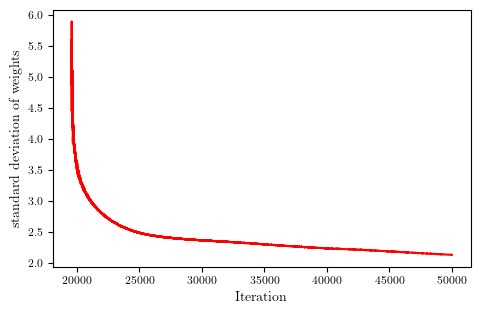

In [81]:
# Plot model evolution path，绘制模型演化路径
J = np.array(mean) * 160
J0 = np.array(std_dev) * 160
print((1/J))
print((J0/J))
x, y = np.log10((J0/J)), np.log10((1/J)) #计算x和y的值，x的值为均值除以方差*50再加上50.5，y的值为100.5减去1除以方差*33.3333

indices=list(range(len(x)))
plt.figure()
# plt.plot(indices[:Adam_iter],trainloss[:Adam_iter],color='red')
# plt.plot(indices[Adam_iter:],trainloss[Adam_iter:],color='blue')

plt.plot(indices, x, color='red')
plt.xlabel('Iteration')
plt.ylabel('standard deviation of weights')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([40000,max(indices)]) # 设置x轴的范围
# plt.ylim([0,2]) # 设置y轴的范围
# plt.yscale('log')  # 设置y轴为对数尺度




# x_optimal = indices[np.argmin(trainloss)] #计算最优点的x坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
# y_optimal = trainloss[np.argmin(trainloss)] #计算最优点的y坐标，这里用了numpy的argmin函数，返回val_loss最小值的索引
# plt.scatter(x_optimal, y_optimal, s=3, marker='o', color='C2', label='Optimal epoch (test loss)', zorder=10) #绘制一个散点图，其中x_optimal和y_optimal是坐标，s表示标记大小，marker表示标记形状o代表圆圈，color表示颜色，label表示图例，zorder表示图层顺序



plt.show()


In [89]:
import pickle


# 使用pickle模块保存数据
with open("results.pkl", "wb") as file:
    pickle.dump(results, file)